# **Predictions and Comparing Models for Predictions**
**Lecture 06**

In [2]:
# [1c]
# Run this cell before continuing.
library(repr)
library(infer)
library(cowplot)
library(broom)
library(GGally)
library(AER)
library(modelr)
library(tidyverse)
library(palmerpenguins)
library(titanic)
library(faraway)

penguins_clean <-
    penguins %>%
    drop_na() 

model_penguins_slr <- lm(body_mass_g ~ flipper_length_mm, data = penguins_clean)
model_penguins_larger <- lm(body_mass_g ~ flipper_length_mm + bill_depth_mm + bill_length_mm, data = penguins_clean) 
penguins_pred_slr <-
    penguins_clean %>%
    add_predictions(model_penguins_slr, var = 'pred')


options(repr.plot.width = 10, repr.plot.height = 5) 

# **1. Variable (Model) Selection**


Some datasets contain *many* variables, but not all of them are relevant. Do we need all the available predictors in the model? You may want to identify the *most relevant* variables to build a model.

But again, what is your goal? Inference or prediction?
    
We need to choose an evaluation metric to decide whether a variable (or set of variables) is relevant. The evaluation metric depends on the goal of the analysis.

## **1.1 Test MSE and RSME**

MSE stands for Mean Square Error. It is a very commonly used quantity to evaluate <font color='darkred'>**models for numerical response**</font>. In fact, this is the quantity the least squares method minimizes to fit a linear regression (in the training data).

$$\text{MSE} = \frac{1}{n}\sum_{i=1}^n(y_i - \hat{y}_i)^2$$

In [3]:
# In the in-sample-mse is just the mean of RSS
mean( model_penguins_slr$residuals ** 2 )

[1] 153789.7

<font color='darkred'>**But remember, we are NOT INTERESTED on in-sample MSE. We want the out-of-sample MSE.**</font>

$$\text{MSE} = \frac{1}{n}\sum_{i=1}^n(y^{\text{new}}_i - \hat{y}_i^{\text{new}})^2$$

or, in R 

```r
MSE <- mean( (prediction - response) ** 2)
```

For example, imagine that the penguin's data was our validation set:

In [4]:
prediction <- penguins_pred_slr$pred 
response <- penguins_pred_slr$body_mass_g

mean( (prediction - response) **2 )

[1] 153789.7

The function for MSE is not implemented in base R. But many different packages implement it. One of them is `modelr`.

In [5]:
# Using modelr
modelr::mse(model_penguins_slr, penguins_clean)

[1] 153789.7

However, since the MSE is the sum of square terms, the measurement unit is also square. To bring the units of measurement back to the unit of $Y$, we can calculate the Root Mean Square Error (RMSE):

$$\text{RMSE} = \sqrt{\frac{1}{n}\sum_{i=1}^n\left(y^{\text{new}}_i - \hat{y}_i^{\text{new}}\right)^2}$$

In [6]:
# Using modelr
modelr::rmse(model_penguins_slr, penguins_clean)

[1] 392.1603

MSE and RMSE are not a good metric for classification problem.

## **1.2 AIC, BIC and $C_p$**

An advantage of these quantities is that they are calculated using the training data. 
So you don't need to use a validation set. 

Since these quantities are based on the likelihood function (which we don't cover in this course). 
So, I'll ommit the formulae. 

- $C_p$
- Akaike Information Criterion (AIC)
- Bayesian Information Criterion (BIC)

The rule to use these quantities for model selection is to select models with <font color='darkred'>**smaller**</font> $C_p$, AIC, or BIC.

$C_p$ and AIC are equivalent, meaning they will select the same models. BIC penalizes complex models more than AIC, so tends to use simpler models.

In [7]:
glance(model_penguins_slr)

r.squared,adj.r.squared,sigma,statistic,p.value,df,logLik,AIC,BIC,deviance,df.residual,nobs
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<int>
0.7620922,0.7613734,393.3433,1060.295,3.132836e-105,1,-2461.073,4928.146,4939.57,51211963,331,333


In [8]:
glance(model_penguins_larger)

r.squared,adj.r.squared,sigma,statistic,p.value,df,logLik,AIC,BIC,deviance,df.residual,nobs
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<int>
0.7639367,0.7617841,393.0046,354.898,9.260836e-103,3,-2459.777,4929.554,4948.595,50814912,329,333


If you are using AIC: 

- The AIC from `model_penguins_slr` is lower than the one from `model_penguins_larger`, therefore, according to AIC, we should pick `model_penguins_slr`.

If you are using BIC
- The BIC from `model_penguins_slr` is lower than the one from `model_penguins_larger`, therefore, according to BIC, we should pick `model_penguins_slr`.

## **1.3 Automated variable selection**

In the last lecture, we talked about the Forward Selection method. Now, you can use AIC or BIC as a criterion. 

Alternatively, one could use the out-of-sample MSE (named MSPE in DSCI 100) as a criterion. But in this case, we need to compute the MSE in the validation set(s) for each step in the forward selection method. 

# **2. Prediction and confidence intervals**

## **2.1 The two sources of variability**

Remember that when we are estimating the model, we are estimating the true regression line based on a random sample. 

<caption><strong>True regression line.</strong></caption>
<img src=attachment:774dfc88-85e8-4209-b809-17178e66c657.png width=800></img>


Since the sample is random, the estimated coefficients will be random as well. So our lines will be random. This is the first source of variability, the sampling variability.
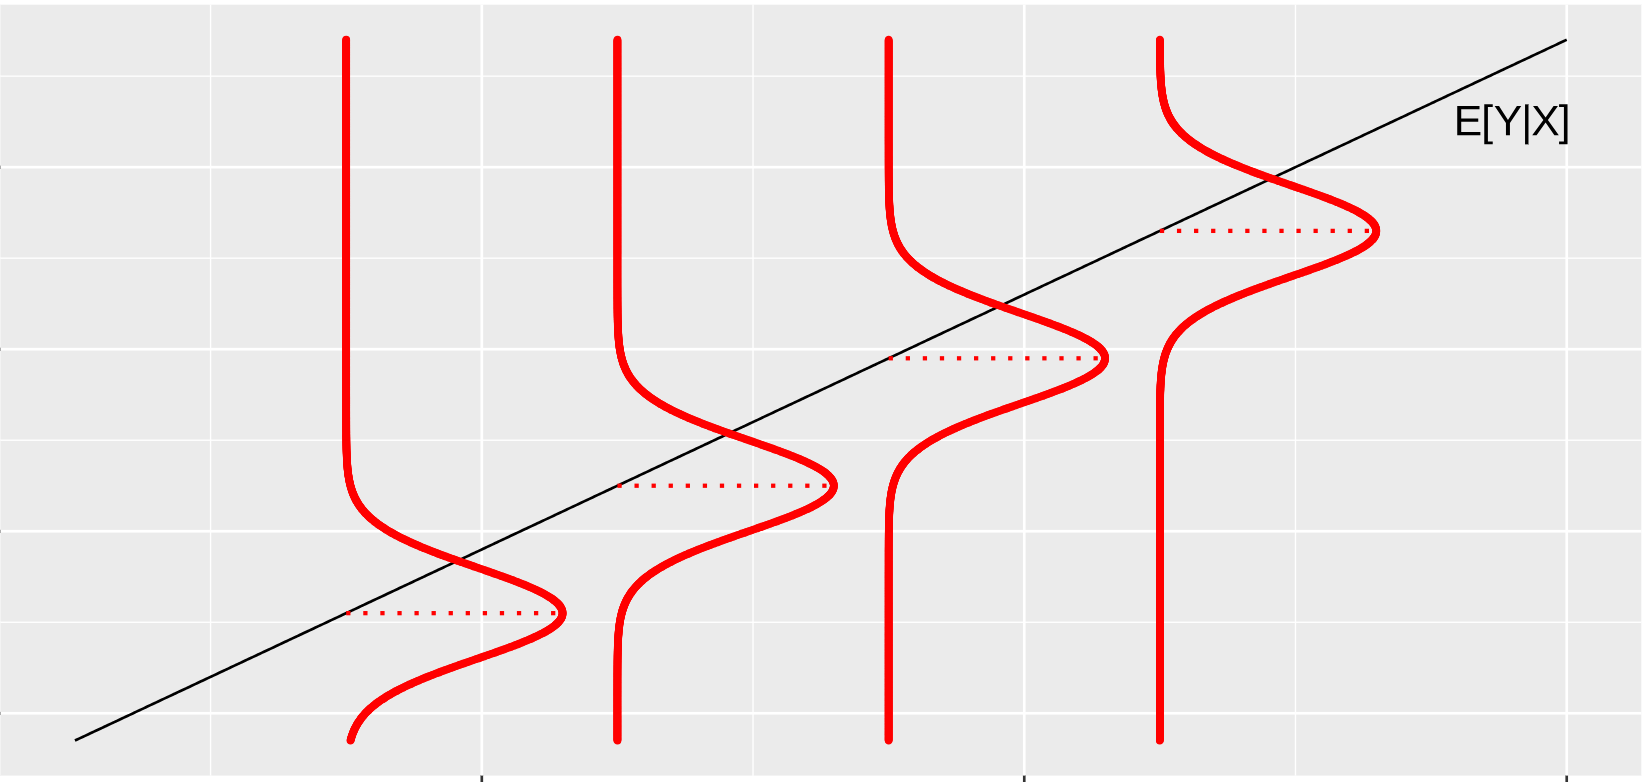

### **2.1.1 Sampling Variability**

Warning message:
“Using `size` aesthetic for lines was deprecated in ggplot2 3.4.0.
ℹ Please use `linewidth` instead.”
`geom_smooth()` using formula = 'y ~ x'


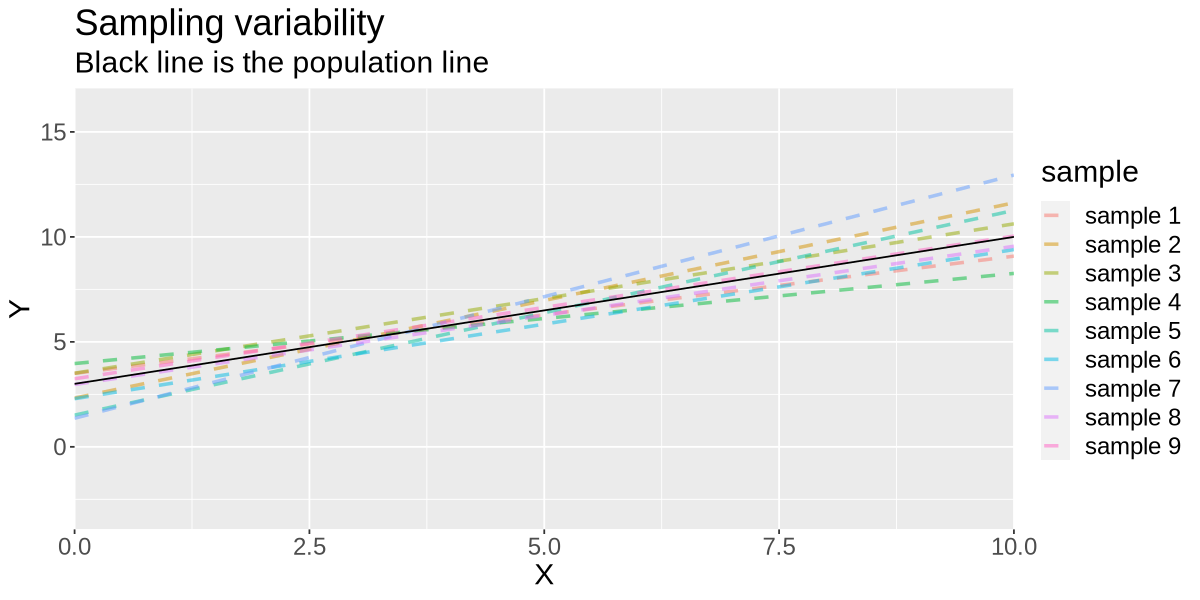

In [9]:
n <- 10
n_samples <- 9
sim_data <- 
    tibble(
        sample = rep(str_c("sample ", as.character(c(1:n_samples))), n),
        X = runif(n * n_samples, 0, 10),
        Y = 0.7 * X + rnorm(n * n_samples, sd = 2) + 3)  %>% 
    arrange(sample)

sim_data %>%
    ggplot(aes(X, Y)) +
    geom_line(aes(color=sample), stat="smooth", method = "lm", 
              size = 1, linetype ="dashed", alpha = 0.5, fullrange = TRUE) + 
    geom_line(data = tibble(X = c(0, 10), Y = c(3, 10))) + 
    scale_x_continuous(expand = c(0,0), limits = c(0, 10)) +
    ggtitle("Sampling variability", subtitle = "Black line is the population line") + 
    theme(text = element_text(size = 18))

### **2.1.2 Population Variability**

Pretend that somehow we devise magical powers and have access to the entire population, in other words, all the points in the population (e.g., all the penguins). Then, we can calculate the coefficients of the true regression line. In this case, we have the population regression, and we don't need sampling. Therefore, no sampling variability is present. 

But we still have variability in the response. 

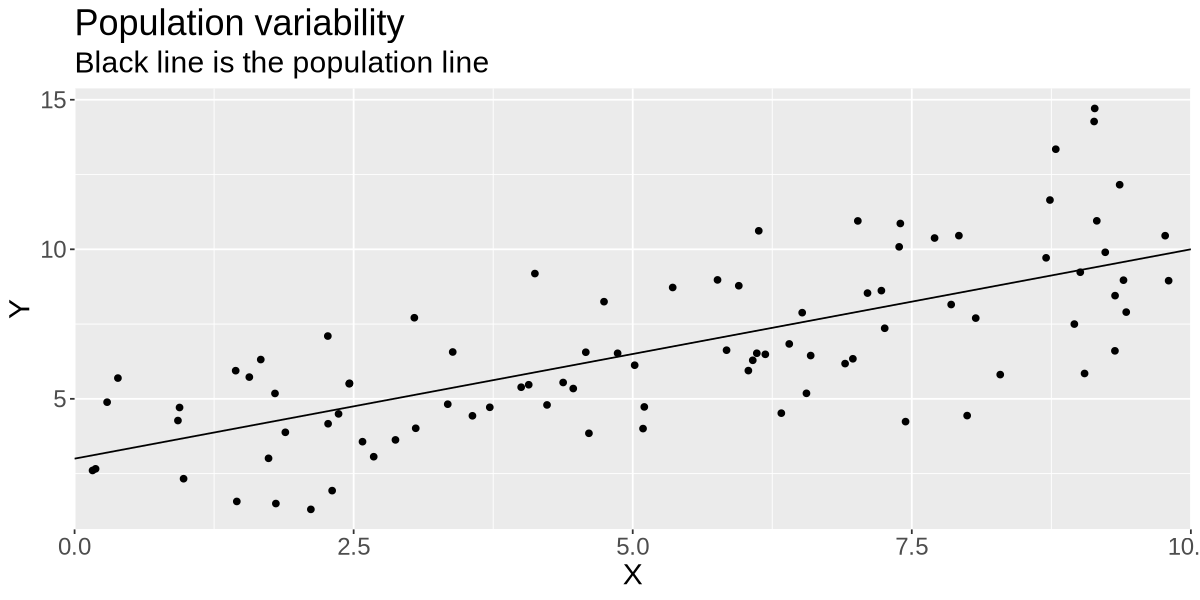

In [10]:
sim_data %>%
    ggplot(aes(X, Y)) +
    geom_point() + 
    geom_line(data = tibble(X = c(0, 10), Y = c(3, 10))) + 
    scale_x_continuous(expand = c(0,0), limits = c(0, 10)) +
    ggtitle("Population variability", subtitle = "Black line is the population line") + 
    theme(text = element_text(size = 18))

This variability comes from the variability in the population due to different elements in the population. For example, different penguins have different `body_mass_g` even if they have the same `flipper_length_mm`. 

In [11]:
penguins %>%
    select(flipper_length_mm, body_mass_g) %>%
    filter(flipper_length_mm == 181)

flipper_length_mm,body_mass_g
<int>,<int>
181,3750
181,3625
181,3300
181,2850
181,3175
181,3700
181,3600


## **2.2 Confidence Interval for Prediction**

Suppose we want to obtain the confidence interval for the regression line, i.e., the confidence interval for $E[Y_i|X_i]$. These are called `Confidence Intervals for Prediction` (CIP). For CIP,  we only deal with sampling variability.

The thing about CIP is that they are narrower when the values of the covariates are closer to their mean and wider as the covariates move away from the mean.

`geom_smooth()` using formula = 'y ~ x'


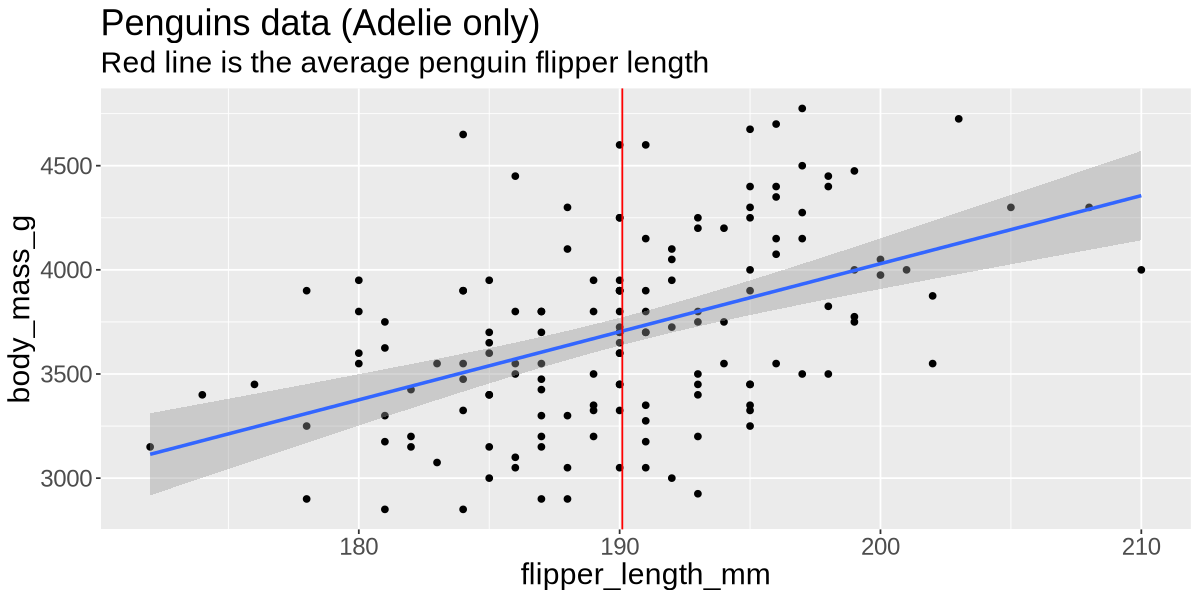

In [12]:
# Let's restrict our attention now to adelie penguins

# Don't worry about this code, focus on the plot 
penguins_adelie <-
    penguins_clean %>%
    filter(species == 'Adelie') %>%
    select(-sex, -year)

mean_flipper_adelie <- mean(penguins_adelie$flipper_length_mm)

penguins_adelie %>%
    ggplot(aes(flipper_length_mm, body_mass_g)) +
    geom_point() + 
    geom_smooth(method=lm) + 
    ggtitle("Penguins data (Adelie only)", subtitle = 'Red line is the average penguin flipper length') + 
    geom_vline(aes(xintercept = mean_flipper_adelie), color = 'red') + 
    theme(text = element_text(size = 18))

## **2.3 Prediction Intervals**

In this case, we are trying to predict the value of the points, not the value of the line. However, to predict the value of the point, we will use the estimated regression line. So we have sources of variability here, such as the variability of estimating the line and the variability of the points around the line. 

For this reason, the Prediction Intervals are wider than the confidence intervals.

In [13]:
# Don't worry about this code, focus on the output
model_adelie <- lm(body_mass_g ~ flipper_length_mm, data = penguins_adelie)

penguins_adelie_conf <- 
    penguins_adelie %>%    
    bind_cols(predict(model_adelie, interval='confidence') %>% 
              as_tibble() %>% 
              rename(pred = fit, cip_lower = lwr, cip_upper = upr)) %>%
    bind_cols(predict(model_adelie, interval='prediction') %>% 
              as_tibble() %>%
              rename(pci_lower = lwr, pci_upper = upr) %>%
              select(-fit)) %>%
    select(flipper_length_mm:pci_upper) %>%
    mutate(len_cip = cip_upper - cip_lower, len_pci = pci_upper - pci_lower) 

penguins_adelie_conf %>%
    head()

Warning message in predict.lm(model_adelie, interval = "prediction"):
“predictions on current data refer to _future_ responses
”


flipper_length_mm,body_mass_g,pred,cip_lower,cip_upper,pci_lower,pci_upper,len_cip,len_pci
<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
181,3750,3408.606,3293.901,3523.311,2595.095,4222.116,229.4102,1627.021
186,3800,3572.050,3493.227,3650.873,2762.819,4381.281,157.6458,1618.462
195,3250,3866.251,3782.793,3949.708,3056.555,4675.946,166.9144,1619.391
193,3450,3800.873,3727.896,3873.849,2992.190,4609.555,145.9531,1617.365
190,3650,3702.806,3636.144,3769.468,2894.669,4510.943,133.3246,1616.274
181,3625,3408.606,3293.901,3523.311,2595.095,4222.116,229.4102,1627.021


`geom_smooth()` using formula = 'y ~ x'


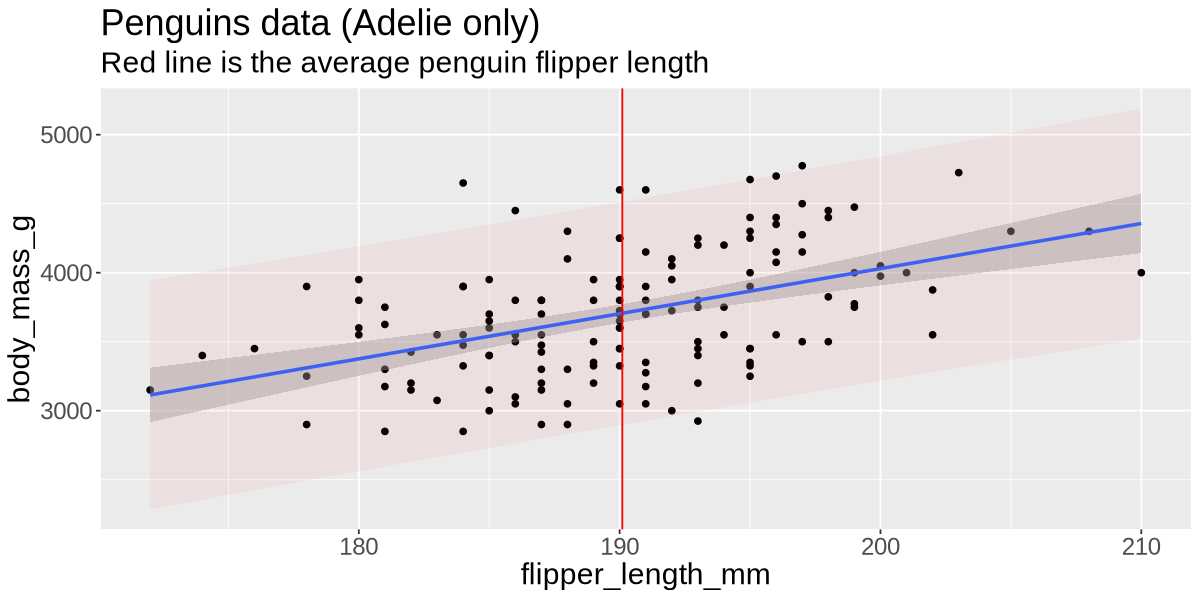

In [14]:
penguins_adelie_conf %>%
    ggplot(aes(flipper_length_mm, body_mass_g)) +
    geom_point() + 
    geom_smooth(method=lm) + 
    ggtitle("Penguins data (Adelie only)", subtitle = 'Red line is the average penguin flipper length') + 
    geom_vline(aes(xintercept = mean_flipper_adelie), color = 'red') + 
    geom_ribbon(aes(ymin = pci_lower, ymax = pci_upper), alpha = 0.05, fill = 'red') +
    theme(text = element_text(size = 18))

- Prediction intervals are narrower when the new observation is closer to the average of the covariates; 
    - This is intuitive since the CIPs are narrower there, and PIs have that uncertainty as well;

# **3. A note on Classification problems**

True Label\Predicted    |    Positive    |    Negative   | Total
:----------------------:|:--------------:|:-------------:|:--------:
Positive                |       TP       |       FN      | TP + FN (total positive)
Negative                |       FP       |       TN      | FP + TN (total negative)
------------------------|----------------|---------------|--------------------------
Total.                  |    TP + FP     |    FN + TN    | n

where
- TP: true positive (i.e., the logistic regression classifies the observation as **positive** and the label is **positive**)
- TN: true negative (i.e., the logistic regression classifies the observation as **negative** and the label is **negative**)
- FN: false negative (i.e., the logistic regression classifies the observation as **negative**, but the label is **positive**)
- FP: false positive (i.e., the logistic regression classifies the observation as **positive**, but the label is **negative**)

## **3.1 A few goodness of fit measures for classification**

### **3.1.1 Accuracy**

The proportion of observations correctly classified.

$$
\text{Accuracy} = \frac{TP + TN}{n}
$$

This is an intuitive and helpful measure; however, it has its flaws. 

Consider a scenario where you are trying to determine if people have a specific disease based on their blood test results. Let's assume the disease is rare, with only 10 out of 10000 people having it.

You can create a very *accurate* classifier by just classifying everyone as healthy. 
$$
\text{Accuracy} = \frac{0 + 9,990}{10,000} = 99.9\%
$$

Extremely accurate classifier and I didn't even need to look at the blood test results! 

But this test is useless since we did not detect **any** of the 10 sick people. Great diagnostic test, eh? 
Everyone is always healthy.

### **3.1.2 Precision**

From the labels classified as positives, what proportion were truly positive?
$$
\text{Precision} = \frac{TP}{TP + FP}
$$

For example, if my blood test says the patient is sick, what is the probability that the patient is sick?

### **3.3 Recall**

From the labels that are truly positives, what proportion were classified as positive?

$$
\text{Recall} = \frac{TP}{TP + FP}
$$

For example, if the patient is sick, what is the probability that the blood test is positive?

## **3.2 Inference in logistic regression**

You can also use the `anova` function to compare **nested** logistic regression models. The theory behind is a little different, in practical terms, we can use it in the same way!